## Dont name your email subject anything other than Assignment# !

In [1]:
%matplotlib inline

Autograd: Automatic Differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given.



In [1]:
import torch

In [2]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


#### We dont need to specify requires_grad = False, since by default it flags it as False

In [4]:
tensor1 = torch.Tensor([[1, 2, 3], 
                       [4, 5, 6]])
tensor1

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [5]:
tensor2 = torch.Tensor([[7, 8, 9], 
                        [10, 11, 12]])

tensor2

tensor([[ 7.,  8.,  9.],
        [10., 11., 12.]])

#### The requires_grad property defines whether to track operations on this tensor
By default, it is set to False

In [6]:
tensor1.requires_grad

False

In [7]:
tensor2.requires_grad

False

#### The requires\_grad\_() function sets requires_grad to True

In [8]:
tensor1.requires_grad_()

tensor([[1., 2., 3.],
        [4., 5., 6.]], requires_grad=True)

In [9]:
tensor1.requires_grad

True

In [10]:
tensor2.requires_grad

False

#### The .grad property stores all the gradients for the tensor
However, there are no gradients yet

In [11]:
print(tensor1.grad)

None


#### The .grad_fn property contains the gradient function
This has not been set either

In [12]:
print(tensor1.grad_fn)

None


#### Create a new output tensor from our original tensor

In [13]:
output_tensor = tensor1 * tensor2

#### The requires_grad property has been derived from the original tensor

In [14]:
output_tensor.requires_grad

True

#### There are still no gradients

In [15]:
print(output_tensor.grad)

None


/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


#### But there is a gradient function
This is from the multiplication operation performed on the original tensor 

In [16]:
print(output_tensor.grad_fn)

#### The original tensor still does not have a gradient function

In [17]:
print(tensor1.grad_fn)

None


In [18]:
print(tensor2.grad_fn)

None


#### Changing the operation for the output changes the gradient function
The gradient function only contains the last operation. Here, even though there is a multiplication as well as a mean, only the mean calculation is recorded as the gradient function

In [19]:
output_tensor = (tensor1 * tensor2).mean()
print(output_tensor.grad_fn)

#### In spite of setting a gradient function for the output, the gradients for the input tensor is still empty

In [20]:
print(tensor1.grad)

None


#### To calculate the gradients, we need to explicitly perform a backward propagation

In [21]:
output_tensor.backward()

#### The gradients are now available for the input tensor

Future calls to backward will accumulate gradients into this vector

In [22]:
print(tensor1.grad)

tensor([[1.1667, 1.3333, 1.5000],
        [1.6667, 1.8333, 2.0000]])


#### The gradient vector is the same shape as the original vector

In [23]:
tensor1.grad.shape, tensor1.shape

(torch.Size([2, 3]), torch.Size([2, 3]))

In [24]:
print(tensor2.grad)

None


In [25]:
print(output_tensor.grad)

None


/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


#### The requires_grad property propagates to other tensors
Here the new_tensor is created from the original tensor and gets the original's value of requires_grad

In [26]:
new_tensor = tensor1 * 3
print(new_tensor.requires_grad)

True


In [27]:
new_tensor

tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]], grad_fn=<MulBackward0>)

#### Turning off gradient calculations for tensors
You can also stops autograd from tracking history on newly created tensors with requires_grad=True by wrapping the code block in <br />
<b>with torch.no_grad():</b>

In [28]:
with torch.no_grad():
    
    new_tensor = tensor1 * 3
    
    print('new_tensor = ', new_tensor)
    
    print('requires_grad for tensor = ', tensor1.requires_grad)
    
    print('requires_grad for tensor = ', tensor2.requires_grad)
    
    print('requires_grad for new_tensor = ', new_tensor.requires_grad)

new_tensor =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]])
requires_grad for tensor =  True
requires_grad for tensor =  False
requires_grad for new_tensor =  False


#### Can turn off gradient calculations performed within a function

In [29]:
def calculate(t):
    return t * 2

In [30]:
@torch.no_grad()
def calculate_with_no_grad(t):
    return t * 2

In [31]:
result_tensor = calculate(tensor1)

result_tensor

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]], grad_fn=<MulBackward0>)

In [32]:
result_tensor.requires_grad

True

In [33]:
result_tensor_no_grad = calculate_with_no_grad(tensor1)

result_tensor_no_grad

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]])

In [34]:
result_tensor_no_grad.requires_grad

False

#### Can explicitly enabled gradients within a no_grad() context

There is an equivalent @torch.enable_grad() as well

In [35]:
with torch.no_grad():
    
    new_tensor_no_grad = tensor1 * 3
    
    print('new_tensor_no_grad = ', new_tensor_no_grad)
    
    with torch.enable_grad():
        
        new_tensor_grad = tensor1 * 3
    
        print('new_tensor_grad = ', new_tensor_grad)

new_tensor_no_grad =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]])
new_tensor_grad =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]], grad_fn=<MulBackward0>)


### Result tensors get requires_grad properties from input tensors

In [5]:
tensor_one = torch.tensor([[1.0, 2.0], 
                           [3.0, 4.0]], requires_grad=True)  
tensor_one

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [37]:
tensor_two = torch.Tensor([[5, 6], 
                           [7, 8]])
tensor_two

tensor([[5., 6.],
        [7., 8.]])

#### enable the gradients for  two tensors

In [38]:
tensor_one.requires_grad

True

In [39]:
tensor_two.requires_grad_()

tensor([[5., 6.],
        [7., 8.]], requires_grad=True)

In [40]:
final_tensor = (tensor_one + tensor_two).mean()
final_tensor

tensor(9., grad_fn=<MeanBackward0>)

#### final tensor has gradients enabled as it derives from the tensors its made up of

In [41]:
final_tensor.requires_grad

True

In [42]:
print(tensor_one.grad)

None


In [43]:
print(tensor_two.grad)

None


In [44]:
final_tensor.backward()

In [45]:
print(tensor_one.grad)

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])


In [46]:
print(tensor_two.grad)

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])


In [47]:
print(final_tensor.grad)

None


/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


#### Detach tensors from the computation graph

In [6]:
detached_tensor = tensor_one.detach()

detached_tensor

tensor([[1., 2.],
        [3., 4.]])

In [7]:
tensor_one

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [9]:
mean_tensor = (tensor_one + detached_tensor).mean()

mean_tensor.backward()

# Trace It your self!

In [12]:
a = torch.randn(2, 2).requires_grad_()
a = ((a * 3) / (a - 1))
b = (a * a).sum()

In [13]:
import torch
from graphviz import Digraph
import torch
from torch.autograd import Variable

#look at https://github.com/szagoruyko/pytorchviz
def make_dot(var, params):
    param_map = {id(v): k for k, v in params.items()}
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot
g = make_dot(b,{})
g



ModuleNotFoundError: No module named 'graphviz'

In [53]:
def trackIt(inp):
    if inp is None:
        return None
    if hasattr(inp,'grad_fn'):
        print(type(inp.grad_fn))
        trackIt(inp.grad_fn.next_functions)
        return None
    if type(inp) is tuple:
        for u in inp:
            trackIt(u[0])
        return None
    if hasattr(inp, 'next_functions'):
        if "AccumulateGrad" not in str(type(inp)):
            print(type(inp))
        trackIt(inp.next_functions)
        return None

trackIt(b) #Trace it your self!

<class 'SumBackward0'>
<class 'MulBackward0'>
<class 'DivBackward0'>
<class 'MulBackward0'>
<class 'SubBackward0'>
<class 'DivBackward0'>
<class 'MulBackward0'>
<class 'SubBackward0'>


## Variable

In [54]:
import torch 

from torch.autograd import Variable

#### We create a Variable with Float tensor

The return value is not a variable instead it is a tensor

In [55]:
var = Variable(torch.FloatTensor([9]))
var

tensor([9.])

In [56]:
var.requires_grad

False

In [57]:
var.requires_grad_()

tensor([9.], requires_grad=True)

#### We create two weight variables with gradients enabled

In [58]:
w1 = Variable(torch.FloatTensor([3]), requires_grad = True)
w2 = Variable(torch.FloatTensor([7]), requires_grad = True)

In [59]:
w1

tensor([3.], requires_grad=True)

In [60]:
w2

tensor([7.], requires_grad=True)

#### We create two more variables using the weights

In [61]:
result_var = var * w1

result_var 

tensor([27.], grad_fn=<MulBackward0>)

#### New variables derive enabled gradients from weights

In [62]:
result_var.requires_grad

True

In [63]:
result_var.backward()

In [64]:
w1.grad

tensor([9.])

In [65]:
w2.grad

In [66]:
var.grad

tensor([3.])

Gradients
---------
Let's backprop now.
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1.))``.



In [67]:
import torch

Create a tensor and set ``requires_grad=True`` to track computation with it



In [68]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation:



In [69]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.




In [70]:
print(y.grad_fn)

Do more operations on ``y``



In [71]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [72]:
out.backward()

Print gradients d(out)/dx




In [73]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.

Mathematically, if you have a vector valued function $\vec{y}=f(\vec{x})$,
then the gradient of $\vec{y}$ with respect to $\vec{x}$
is a Jacobian matrix:

\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}

Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector
$v=\left(\begin{array}{cccc} v_{1} & v_{2} & \cdots & v_{m}\end{array}\right)^{T}$,
compute the product $v^{T}\cdot J$. If $v$ happens to be
the gradient of a scalar function $l=g\left(\vec{y}\right)$,
that is,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$,
then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

(Note that $v^{T}\cdot J$ gives a row vector which can be
treated as a column vector by taking $J^{T}\cdot v$.)

This characteristic of vector-Jacobian product makes it very
convenient to feed external gradients into a model that has
non-scalar output.



Now let's take a look at an example of vector-Jacobian product:



In [74]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([594.0493, 253.0711, 924.7622], grad_fn=<MulBackward0>)


Now in this case ``y`` is no longer a scalar. ``torch.autograd``
could not compute the full Jacobian directly, but if we just
want the vector-Jacobian product, simply pass the vector to
``backward`` as argument:



In [75]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


You can also stop autograd from tracking history on Tensors
with ``.requires_grad=True`` by wrapping the code block in
``with torch.no_grad():``


In [76]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


In [77]:
from torch.autograd import Function

class mysin(Function):
    @staticmethod
    def forward(ctx,i):
        ctx.save_for_backward(i)
        return i.sin()
    
    @staticmethod
    def backward(ctx,grad_output):
        print("my backward called")
        i, = ctx.saved_tensors
        return grad_output*i.cos()
    

a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
t = (a * a).sum()
b = mysin.apply(t)
b = b+1
trackIt(b)


False
True
<class 'AddBackward0'>
<class 'torch.autograd.function.mysinBackward'>
<class 'SumBackward0'>
<class 'MulBackward0'>


In [78]:
b.backward()
print(inp.grad)

#Read more:https://pytorch.org/docs/master/notes/extending.html

my backward called


NameError: name 'inp' is not defined

**Read Later:**

Documentation of ``autograd`` and ``Function`` is at
https://pytorch.org/docs/autograd


# Linear Regression
<img src="linreg1.jpg">
<img src="linreg2.jpg">

In [79]:
import numpy as np 
import matplotlib.pyplot as plt

#### Creating Dataset
A simple dataset using numpy arrays

In [80]:
x_train = np.array ([[4.7], [2.4], [7.5], [7.1], [4.3], [7.816], 
                     [8.9], [5.2], [8.59], [2.1], [8] , 
                     [10], [4.5], [6], [4]],
                    dtype = np.float32)

y_train = np.array ([[2.6], [1.6], [3.09], [2.4], [2.4], [3.357], 
                     [2.6], [1.96], [3.53], [1.76], [3.2] , 
                     [3.5], [1.6], [2.5], [2.2]], 
                    dtype = np.float32)

#### View the data
There seems to be some relationship which can be plotted between x_train and y_train. A regression line can be drawn to represent the relationship

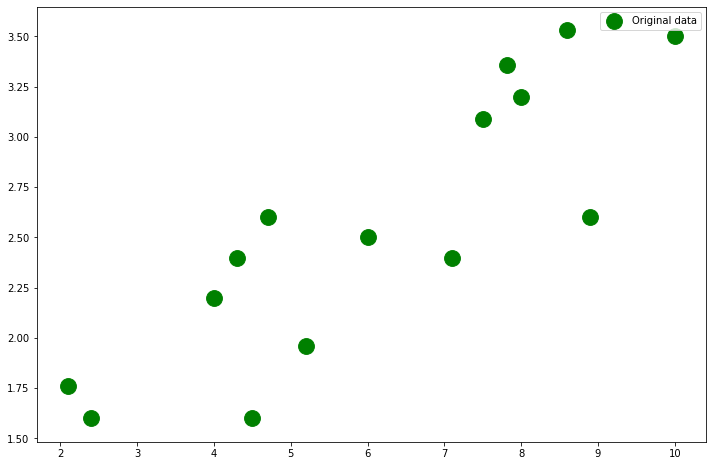

In [81]:
plt.figure(figsize=(12, 8))

plt.scatter(x_train, y_train, label='Original data', s=250, c='g')

plt.legend()
plt.show()

In [82]:
import torch 

#### Converting data to pytorch tensors
By defualt requires_grad = False

In [83]:
X_train = torch.from_numpy(x_train) 
Y_train = torch.from_numpy(y_train)

print('requires_grad for X_train: ', X_train.requires_grad)
print('requires_grad for Y_train: ', Y_train.requires_grad)

requires_grad for X_train:  False
requires_grad for Y_train:  False


#### Set the details for our neural network
Input, output and hidden layer sizes plus the learning rate

In [84]:
input_size = 1 
hidden_size = 1
output_size = 1

#### Create random Tensors for weights.<br>
Setting requires_grad=True indicates that we want to compute gradients with respect to these Tensors during the backward pass

In [85]:
w1 = torch.rand(input_size, 
                hidden_size, 
                
                requires_grad=True)
w1.shape

torch.Size([1, 1])

In [86]:
w2 = torch.rand(hidden_size, 
                output_size, 
                
                requires_grad=True)
w2.shape

torch.Size([1, 1])

## Training

#### Foward Pass:
* Predicting Y with input data X
* finding (matrix X matrix) using .mm function, finding product of X_train and w1 and activation function is identity function
* again doing mat product data with second weight w2

#### Finding Loss:
* Finding difference between Y_train and Y_pred by squaring the difference and then summing out, similar to nn.MSELoss 


#### For the loss_backward() function call:
* backward pass will compute the gradient of loss with respect to all Tensors with requires_grad=True. 
* After this call w1.grad and w2.grad will be Tensors holding the gradient of the loss with respect to w1 and w2 respectively.

#### Manually updating the weights
* weights have requires_grad=True, but we don't need to track this in autograd. So will wrap it in torch.no_grad
* reducing weight with multiple of learning rate and gradient
* manually zero the weight gradients after updating weights

In [87]:
learning_rate = 1e-6

In [88]:
# Start at 10. Change this to 100, 1000 and 3000 and run the code all the way to the plot at the bottom
for iter in range(1, 3000):
    
    y_pred = X_train.mm(w1).mm(w2)
    loss = (y_pred - Y_train).pow(2).sum()
    
    if iter % 50 ==0:
        print(iter, loss.item())
        
    loss.backward()
    
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        w1.grad.zero_()
        w2.grad.zero_()

50 35.97338104248047
100 34.311439514160156
150 32.70014190673828
200 31.14057731628418
250 29.633655548095703
300 28.180097579956055
350 26.780445098876953
400 25.435075759887695
450 24.1441707611084
500 22.907690048217773
550 21.725444793701172
600 20.597030639648438
650 19.521926879882812
700 18.499374389648438
750 17.52846908569336
800 16.608234405517578
850 15.737475395202637
900 14.914917945861816
950 14.139177322387695
1000 13.408772468566895
1050 12.722145080566406
1100 12.07768726348877
1150 11.473724365234375
1200 10.90857219696045
1250 10.380496978759766
1300 9.887768745422363
1350 9.428682327270508
1400 9.00150203704834
1450 8.604549407958984
1500 8.236138343811035
1550 7.894645690917969
1600 7.5785017013549805
1650 7.286149501800537
1700 7.01611328125
1750 6.7669525146484375
1800 6.537304878234863
1850 6.325829982757568
1900 6.131318092346191
1950 5.952566146850586
2000 5.788446426391602
2050 5.637892246246338
2100 5.499894618988037
2150 5.373514175415039
2200 5.2578535079

In [89]:
print ('w1: ', w1)
print ('w2: ', w2)

w1:  tensor([[0.5272]], requires_grad=True)
w2:  tensor([[0.7152]], requires_grad=True)


#### Checking the output

Converting data into a tensor

In [90]:
x_train_tensor = torch.from_numpy(x_train)
x_train_tensor

tensor([[ 4.7000],
        [ 2.4000],
        [ 7.5000],
        [ 7.1000],
        [ 4.3000],
        [ 7.8160],
        [ 8.9000],
        [ 5.2000],
        [ 8.5900],
        [ 2.1000],
        [ 8.0000],
        [10.0000],
        [ 4.5000],
        [ 6.0000],
        [ 4.0000]])

#### Get the predicted values using the weights 
Using final weights calculated from our training in order to get the predicted values

In [91]:
predicted_in_tensor = x_train_tensor.mm(w1).mm(w2)
predicted_in_tensor

tensor([[1.7720],
        [0.9048],
        [2.8276],
        [2.6768],
        [1.6212],
        [2.9468],
        [3.3555],
        [1.9605],
        [3.2386],
        [0.7917],
        [3.0162],
        [3.7702],
        [1.6966],
        [2.2621],
        [1.5081]], grad_fn=<MmBackward>)

#### Convert the prediction to a numpy array
This will be used to plot the regression line in a plot

In [92]:
predicted = predicted_in_tensor.detach().numpy()
predicted

array([[1.7719933 ],
       [0.90484774],
       [2.827649  ],
       [2.6768413 ],
       [1.6211855 ],
       [2.9467874 ],
       [3.3554769 ],
       [1.9605033 ],
       [3.238601  ],
       [0.7917418 ],
       [3.016159  ],
       [3.770199  ],
       [1.6965895 ],
       [2.2621193 ],
       [1.5080795 ]], dtype=float32)

#### Plotting
Our training has produced a rather accurate regression line

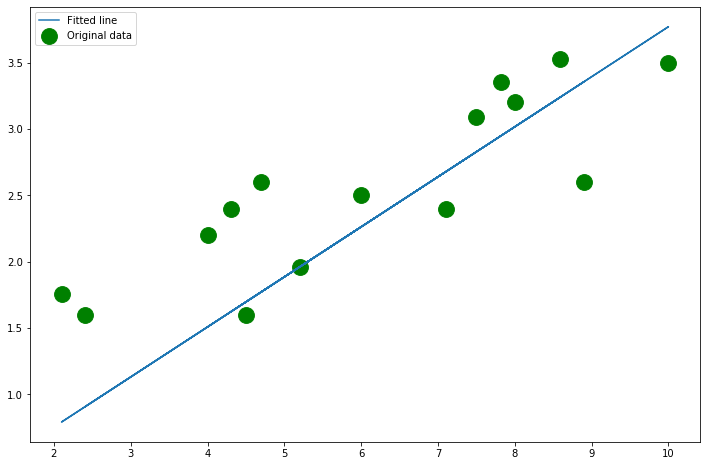

In [93]:
plt.figure(figsize=(12, 8))

plt.scatter(x_train, y_train, label = 'Original data', s=250, c='g') 

plt.plot(x_train, predicted, label = 'Fitted line ')

plt.legend() 

plt.show()

In [94]:
import torch
import matplotlib.pyplot as plt
import numpy as np

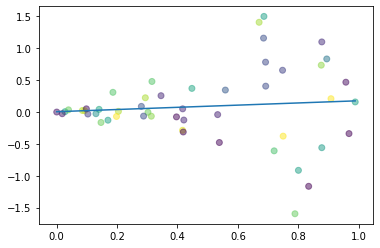

In [95]:
torch.manual_seed(1)
np.random.seed(1)

n=50
x=np.random.rand(n)
y=x*np.random.randn(n)

colors = np.random.rand(n)
plt.plot(np.unique(x),np.poly1d(np.polyfit(x,y,1))(np.unique(x)))

plt.scatter(x,y,c=colors,alpha=0.5)
plt.show()


In [96]:
torch.manual_seed(42)
np.random.seed(42)

N = 64

alpha = 1.3
beta = np.array([[1.9],[1.5]])#

x_data = np.random.randn(N, 2)#
y_data = x_data.dot(beta) + alpha

x=torch.from_numpy(x_data).float()
y=torch.from_numpy(y_data).float()

w_beta = torch.randn((2, 1), requires_grad=True)
w_alpha = torch.randn(1, requires_grad=True)

learning_rate = 1e-2
optimizer = torch.optim.SGD([w_beta, w_alpha], lr=learning_rate)
criterion = torch.nn.MSELoss()
for t in range(1000):
    y_pred = x.mm(w_beta).add(w_alpha)
    
#     loss = (y_pred - y).pow(2).sum()
    loss = criterion(y_pred,y)

    if t % 100 == 0:
        print(t, loss.item())
        if w_alpha.grad is not None and w_beta.grad is not None:
            print("w_alpha Grad = ",w_alpha.grad[0].item()," w_beta Grad = ",w_beta.grad[0].item())
    
    optimizer.zero_grad()   
    
    loss.backward()
    
    optimizer.step()

0 4.748549461364746
100 0.14980310201644897
w_alpha Grad =  -0.3407284617424011  w_beta Grad =  -0.5186246037483215
200 0.005887317471206188
w_alpha Grad =  -0.06525570899248123  w_beta Grad =  -0.11431684345006943
300 0.0002652518742252141
w_alpha Grad =  -0.012681262567639351  w_beta Grad =  -0.02554965950548649
400 1.2771343790518586e-05
w_alpha Grad =  -0.002525575924664736  w_beta Grad =  -0.005741352681070566
500 6.325632853076968e-07
w_alpha Grad =  -0.0005171024240553379  w_beta Grad =  -0.0012920351000502706
600 3.1774302300391355e-08
w_alpha Grad =  -0.00010876217857003212  w_beta Grad =  -0.0002910251496359706
700 1.6044989781249797e-09
w_alpha Grad =  -2.3795757442712784e-05  w_beta Grad =  -6.570004188688472e-05
800 9.764136721379657e-11
w_alpha Grad =  -5.878973752260208e-06  w_beta Grad =  -1.5187851204245817e-05
900 3.0997291539103244e-11
w_alpha Grad =  -5.9497542679309845e-06  w_beta Grad =  -5.8256932788935956e-06


In [97]:
print("Optimized Beta: {0}".format(w_beta))
print("Optimized Alpha: {0}".format(w_alpha))

Optimized Beta: tensor([[1.9000],
        [1.5000]], requires_grad=True)
Optimized Alpha: tensor([1.3000], requires_grad=True)


In [98]:
import torch
import numpy as np
import math

SIZE=100
torch.manual_seed(123)

class DS:
    def __init__(self,size=SIZE):
        self.x=torch.rand(size,1)
        self.y=torch.Tensor(size,1)
dataset=DS()

for i in range(SIZE):
    dataset.y[i,0]=3*dataset.x[i,0]+1


x = dataset.x
y = dataset.y

class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.lin= torch.nn.Linear(1,1)
        
    def forward(self, x):
        return self.lin(x)

model=Model()
lr = 0.01
loss_func=torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for t in range(5000):
    y_pred=model(x)

    loss=loss_func(y_pred,y)

    if t % 500 == 0:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print("Optimized Alpha: ",model.lin.weight[0].item())
print("Optimized Beta: ",model.lin.bias[0].item())


0 9.006211280822754
500 0.004818673711270094
1000 0.0013969732681289315
1500 0.0002295930898981169
2000 1.8603743228595704e-05
2500 6.29012333774881e-07
3000 7.020580117256259e-09
3500 2.2144491101938613e-11
4000 1.5726727212173053e-11
4500 8.915463853287342e-12
Optimized Alpha:  2.9999921321868896
Optimized Beta:  1.0000044107437134


# Logestic Regression
<img src="logreg1.jpg">
<img src="logreg2.jpg">

In [99]:
import torch
import numpy as np
import math

SIZE = 100
torch.manual_seed(123)


class DS:
    def __init__(self, size=SIZE):
        self.x = torch.rand(size, 2)
        self.y = torch.LongTensor(size)
        print("New Dataset")
        for i in range(SIZE):
            if (torch.sum(self.x[i]) > 1):
                self.y[i] = 1
            else:
                self.y[i] = 0


dataset = DS()


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin = torch.nn.Linear(2, 2)

    def forward(self, x):
        return self.lin(x)
    


model = Model()
print(list(model.parameters()))
lr = 0.01
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for t in range(10000):
    if t % 10000 == 0:
        dataset = DS()
    y_pred = model(dataset.x)

    loss = loss_func(y_pred, dataset.y)
    
    
    if t % 1000 == 0:
        _, pred = torch.max(y_pred, 1)

        predTmp = pred.type(torch.FloatTensor).clone()
        yTmp = dataset.y.float().clone()
        # print(predTmp)
        # print(yTmp)
        acc = ((predTmp.data == yTmp).sum().float() / float(len(yTmp))) * 100.
        print("Step=",t," Loss=", loss.item(), " Acc=", acc.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print()
print("Optimized Alpha: ", model.lin.weight)
print("Optimized Beta: ", model.lin.bias)


New Dataset
[Parameter containing:
tensor([[-0.1968,  0.0459],
        [ 0.2205, -0.2500]], requires_grad=True), Parameter containing:
tensor([-0.5479,  0.0048], requires_grad=True)]
New Dataset
Step= 0  Loss= 0.6901295185089111  Acc= 56.0
Step= 1000  Loss= 0.15912511944770813  Acc= 97.0
Step= 2000  Loss= 0.10199519246816635  Acc= 99.0
Step= 3000  Loss= 0.07604885846376419  Acc= 99.0
Step= 4000  Loss= 0.06001458689570427  Acc= 99.0
Step= 5000  Loss= 0.048503149300813675  Acc= 100.0
Step= 6000  Loss= 0.03951720520853996  Acc= 100.0
Step= 7000  Loss= 0.032163333147764206  Acc= 100.0
Step= 8000  Loss= 0.026012104004621506  Acc= 100.0
Step= 9000  Loss= 0.020856790244579315  Acc= 100.0

Optimized Alpha:  Parameter containing:
tensor([[-37.1544, -36.4242],
        [ 37.1780,  36.2200]], requires_grad=True)
Optimized Beta:  Parameter containing:
tensor([ 36.2547, -36.7978], requires_grad=True)


### PyTorch MNIST Example

In [100]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand

if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

print(avDev)
'''
STEP 1: LOADING DATASET
'''
 
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
'''
STEP 2: MAKING DATASET ITERABLE
'''
 
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
 
'''
STEP 3: CREATE MODEL CLASS
'''
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, 300)
        self.linear2 = nn.Linear(300, output_dim)
        self.relu = nn.ReLU()
     
    def forward(self, x):
        out = self.relu(self.linear1(x))
        out = self.linear2(out)
        return out
 
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
output_dim = 10
 
model = LogisticRegressionModel(input_dim, output_dim)

cpu


In [101]:
#######################
#  USE GPU FOR MODEL  #
#######################
 
model.to(avDev)
 
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss().to(avDev)

 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.001
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

 
'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         
        #print(images.size()) #torch.Size([100, 1, 28, 28])
        #print(images.view(-1, 28*28).size()) #torch.Size([100, 784])
        images = images.view(-1, 28*28).to(avDev)
        labels = labels.to(avDev)
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)#
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(avDev)
                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                correct += (predicted.cpu() == labels.cpu()).sum().float()
             
            accuracy = 100. * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.1999120712280273. Accuracy: 47.150001525878906
Iteration: 1000. Loss: 2.0818870067596436. Accuracy: 62.68000030517578
Iteration: 1500. Loss: 1.911210298538208. Accuracy: 67.51000213623047
Iteration: 2000. Loss: 1.7680374383926392. Accuracy: 71.43000030517578
Iteration: 2500. Loss: 1.6104234457015991. Accuracy: 74.0199966430664
Iteration: 3000. Loss: 1.5309475660324097. Accuracy: 76.5199966430664
Iteration: 3500. Loss: 1.3537623882293701. Accuracy: 78.05000305175781
Iteration: 4000. Loss: 1.208117127418518. Accuracy: 79.73999786376953
Iteration: 4500. Loss: 1.1188465356826782. Accuracy: 81.0199966430664


# CIFAR-10 Data

In [102]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 
'''
STEP 1: LOADING DATASET
'''

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [103]:
len(trainset)

50000

In [104]:
len(testset)

10000

In [105]:
trainset[1][0].size()

torch.Size([3, 32, 32])

In [106]:
trainset[1][1]

9

In [107]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [108]:
CLASSES[trainset[1][1]]

'truck'

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
trainset[0][0].numpy().shape

(3, 32, 32)

torch.Size([3, 32, 32])


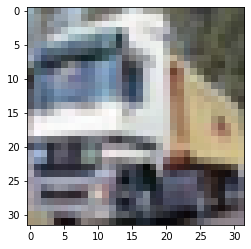

In [110]:
img = trainset[1][0]
_to_pil = transforms.ToPILImage()

print(img.shape)
plt.imshow(_to_pil(img))

# Assignment 2

- Training a Logistic Regression Classifier with CIFAR-10 dataset using PyTorch
- Draw learning curve and confusion matrix
- Find the best hyperparameters
- Plot gradient norm for each learnable parameter
- Extra point:
    - Use hyper-opt package to optimize two hyper-parameters

## Refrences:
### https://www.pluralsight.com/ (Foundation to PyTorch class)
### Pytorch Documents
### https://www.udemy.com/course/practical-deep-learning-with-pytorch/